<a href="https://colab.research.google.com/github/amedyukhina/biomassters/blob/main/biomassters_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Benchmark

Adapted from https://github.com/fnands/BioMassters_baseline/blob/main/unet_baseline.ipynb

In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
rasterio==1.2.0
boto3==1.26.16
pytorch_lightning
segmentation_models_pytorch

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
import os
import rasterio
import pandas as pd
from tqdm import tqdm
import numpy as np

import boto3
from botocore import UNSIGNED
from botocore.config import Config

from cachetools import cached, TTLCache

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import os
from torchvision.io import read_image
import rasterio
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import warnings
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import shutil
from scipy import ndimage
# import wandb

# Our rasters contain no geolocation info, so silence this warning from rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Prepare list of chip IDs

In [5]:
feature_path = 'gdrive/MyDrive/biomassters/info/features_metadata.csv'
train_img_dir = 'train_features'
test_img_dir = 'test_features'
label_dir = 'train_agbm'
output_dir = 'predicted'

In [6]:
df = pd.read_csv(feature_path)

In [7]:
df_pred = df[df['split'] == 'test'].reset_index(drop=True)
pred_ids = np.unique(df_pred['chip_id'])
len(df_pred), len(pred_ids)

(63348, 2773)

In [8]:
df = df[df['split'] == 'train'].reset_index(drop=True)
all_ids = np.unique(df['chip_id'])
len(df), len(all_ids)

(189078, 8689)

In [9]:
np.random.seed(42)
np.random.shuffle(all_ids)

In [10]:
train_ids = all_ids[:500]
val_ids = all_ids[500:550]

### Set up data loading

In [11]:
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
os.environ["AWS_NO_SIGN_REQUEST"] = 'YES'
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [12]:
cache = TTLCache(maxsize=1000, ttl=86400)

In [13]:
@cached(cache)
def get_image(fn):
  obj = s3.get_object(Bucket=BUCKET_NAME, Key=fn)
  with rasterio.open(obj['Body']) as src:
    img = src.read()
  return img

### Calculate mean and std of the dataset

In [14]:
imgs = np.array([get_image(os.path.join(train_img_dir, 
                                        rf"{chip_id}_S2_10.tif"))[:10].astype(np.float32)
for chip_id in tqdm(train_ids)])

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
imgs.shape

(500, 10, 256, 256)

In [16]:
MEANS = np.array([imgs[:,i].mean() for i in range(imgs.shape[1])])
STDS = np.array([imgs[j,i].std() for j in range(imgs.shape[0]) 
  for i in range(imgs.shape[1])]).reshape((imgs.shape[:2])).mean(0)
MEANS, STDS

(array([ 380.4021 ,  535.0182 ,  421.57675,  817.7593 , 1889.2316 ,
        2205.7764 , 2321.24   , 2394.7937 , 1272.0664 ,  702.64954],
       dtype=float32),
 array([319.6245 , 349.22687, 364.47675, 454.4305 , 777.2495 , 899.8386 ,
        970.10986, 952.7745 , 607.3759 , 443.7978 ], dtype=float32))

### Define a dataset

In [17]:
class SentinelDataset2(Dataset):
    def __init__(self, chip_ids, img_dir, label_dir=None, 
                 transform=None, target_transform=None):
        self.chip_ids = chip_ids
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        image = get_image(os.path.join(self.img_dir, 
                                       rf"{self.chip_ids[idx]}_S2_10.tif"))
        image = torch.tensor(image.astype(np.float32)[:10])
        image = (image - 
                 torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)
        
        if self.label_dir is not None:
            label = get_image(os.path.join(self.label_dir, 
                                           rf"{self.chip_ids[idx]}_agbm.tif"))
            label = ndimage.median_filter(label[0], 3)
            label = torch.tensor(label.astype(np.float32)).unsqueeze(0)
        else:
            label = None

        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [18]:
train_ds = SentinelDataset2(train_ids, train_img_dir, label_dir)
val_ds = SentinelDataset2(val_ids, train_img_dir, label_dir)
train_dataloader = DataLoader(train_ds, batch_size=32, 
                              shuffle=True, num_workers = 2)
valid_dataloader = DataLoader(val_ds, batch_size=32, 
                              shuffle=False, num_workers = 2)

test_ds = SentinelDataset2(pred_ids, test_img_dir)
test_dataloader = DataLoader(test_ds, batch_size=32, 
                             shuffle=True, num_workers = 2)

In [19]:
torch.random.manual_seed(42)

In [20]:
imgs, labels = next(iter(train_dataloader))

In [21]:
imgs.shape, labels.shape

(torch.Size([32, 10, 256, 256]), torch.Size([32, 1, 256, 256]))

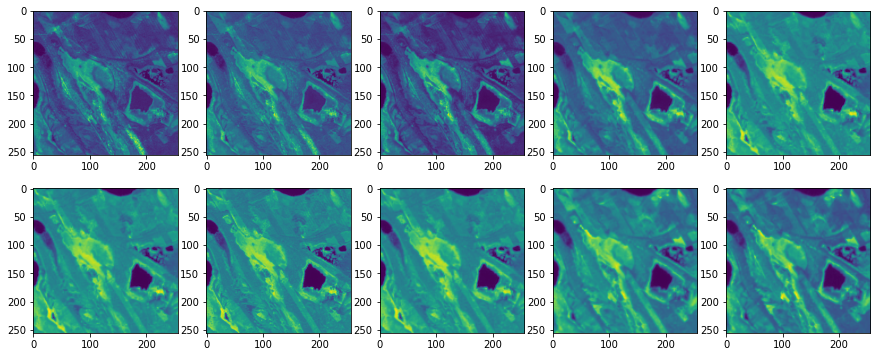

In [22]:
cols = 5
rows = 2
s = 3
fig, axes = plt.subplots(rows, cols, figsize=(s*cols, s*rows))
for img, ax in zip(imgs[0], axes.ravel()):
    ax.imshow(img.numpy())

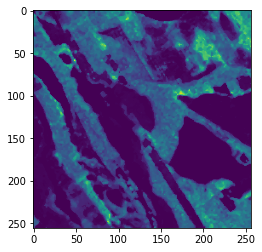

In [23]:
# Show ground truth
plt.imshow(labels[0][0].numpy())

### Define the model and the training pipeline

In [24]:
class Sentinel2Model(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("valid/loss", loss)
        self.log("valid/rmse", torch.sqrt(loss))
        print("valid/rmse", np.sqrt(loss.item()))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def forward(self, x):
        return self.model(x)

In [25]:
base_model = smp.Unet(
    encoder_name="resnet50",       
    in_channels=10,                 
    classes=1,                     
)

In [26]:
!wget https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt

--2022-11-30 05:49:19--  https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94566017 (90M) [application/octet-stream]
Saving to: ‘resnet50-sentinel2.pt.3’

resnet50-sentinel2. 100%[===================>]  90.18M  4.55MB/s    in 1m 58s  

2022-11-30 05:51:19 (780 KB/s) - ‘resnet50-sentinel2.pt.3’ saved [94566017/94566017]



In [27]:
base_model.encoder.load_state_dict(torch.load("resnet50-sentinel2.pt"))
s2_model = Sentinel2Model(base_model)

In [28]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=20,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train

In [29]:
%%time
# Train the model ⚡
trainer.fit(s2_model, train_dataloaders=train_dataloader, 
            val_dataloaders=valid_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 32.5 M
-------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.172   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

valid/rmse 85.68452253670876
valid/rmse 107.77836416113394


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid/rmse 353770.4074452808
valid/rmse 296381.0770747687


Validation: 0it [00:00, ?it/s]

valid/rmse 1197.803980207112
valid/rmse 524.5290745039783


Validation: 0it [00:00, ?it/s]

valid/rmse 113.1555207446813
valid/rmse 71.54426623601643


Validation: 0it [00:00, ?it/s]

valid/rmse 45.15979522199129
valid/rmse 56.74666367189022


Validation: 0it [00:00, ?it/s]

valid/rmse 49.81510001448481
valid/rmse 57.3768424608853


Validation: 0it [00:00, ?it/s]

valid/rmse 45.7454584921416
valid/rmse 58.848749289757635


Validation: 0it [00:00, ?it/s]

valid/rmse 46.85145502426392
valid/rmse 57.306584942172


Validation: 0it [00:00, ?it/s]

valid/rmse 48.95860316858264
valid/rmse 60.350287709028365


Validation: 0it [00:00, ?it/s]

valid/rmse 44.93486496968418
valid/rmse 54.52259288373605


Validation: 0it [00:00, ?it/s]

valid/rmse 48.46175300075566
valid/rmse 60.58355139160092


Validation: 0it [00:00, ?it/s]

valid/rmse 46.4262898649569
valid/rmse 61.34972151589708


Validation: 0it [00:00, ?it/s]

valid/rmse 46.935827720709526
valid/rmse 56.14409518220171


Validation: 0it [00:00, ?it/s]

valid/rmse 49.56843044595017
valid/rmse 60.5088085981599


Validation: 0it [00:00, ?it/s]

valid/rmse 47.73748711213494
valid/rmse 64.17601223880305


Validation: 0it [00:00, ?it/s]

valid/rmse 47.89131575766112
valid/rmse 58.1694638400381


Validation: 0it [00:00, ?it/s]

valid/rmse 44.517393677570006
valid/rmse 53.33857116410342


Validation: 0it [00:00, ?it/s]

valid/rmse 42.916135400736806
valid/rmse 55.090082921775725


Validation: 0it [00:00, ?it/s]

valid/rmse 48.06242888486286
valid/rmse 53.76239410155811


Validation: 0it [00:00, ?it/s]

valid/rmse 42.66548377622566
valid/rmse 55.5736486108468


Validation: 0it [00:00, ?it/s]

valid/rmse 43.89024118735707
valid/rmse 54.11916060806815


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


CPU times: user 2min 20s, sys: 2min 1s, total: 4min 21s
Wall time: 6min 55s


### Show example predictions

In [32]:
s2_model.cuda();

In [33]:
imgs, labels = next(iter(train_dataloader))
pred = s2_model(imgs.cuda())

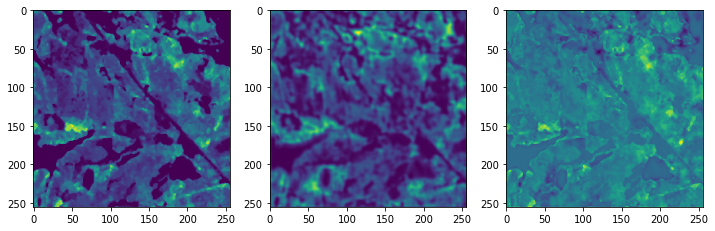

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(ndimage.median_filter(labels[0].numpy()[0], 3))
axes[1].imshow(pred[0].cpu().detach().numpy()[0])
axes[2].imshow(ndimage.median_filter(labels[0].numpy()[0], 3) - pred[0].cpu().detach().numpy()[0])

### Prediction

In [ ]:
os.makedirs(output_dir, exist_ok=True)
s2_model.cuda();
for chip_id in tqdm(pred_ids):
    image = get_image(os.path.join(test_img_dir, 
                                   rf"{chip_id}_S2_10.tif"))
    image = torch.tensor(image.astype(np.float32)[:10])
    image = (image - 
              torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)

    pred = s2_model(image.unsqueeze(0).cuda())
    im = Image.fromarray(pred.squeeze().cpu().detach().numpy())
    im.save(f"{output_dir}/{chip_id}_agbm.tif", format="TIFF", save_all=True)

  0%|          | 0/2773 [00:00<?, ?it/s]

In [ ]:
shutil.make_archive('submission', 'zip', output_dir)

In [ ]:
from google.colab import files
files.download('submission.zip')